In [32]:
import math
import random
from typing import Tuple, NamedTuple


class QuantumMeasurement(NamedTuple):
    """量子測定の結果を表現する型"""
    value: int  # 測定結果 (0 or 1)
    angle: float  # 測定角度（ラジアン）


class EntangledParticles:
    """量子もつれをシミュレートするクラス"""

    def __init__(self):
        self.mesurement: QuantumMeasurement | None = None

    def measure(self, angle: float) -> int:
        """
        特定の角度から量子もつれを観測する

        Args:
            angle (float): 観測する角度（ラジアン）

        Returns:
            int: 観測結果（0 or 1）
        """
        if not self.mesurement:
            self.mesurement = QuantumMeasurement(
                angle=angle,
                value=random.randint(0, 1)
            )
            return self.mesurement.value
        else:
            angle_diff = abs(angle - self.mesurement.angle)
            same_prob = math.sin(angle_diff / 2) ** 2
            return self.mesurement.value if random.random() < same_prob else 1 - self.mesurement.value


class QuantumPlayer:
    """量子戦略を使用するCHSHゲームのプレイヤー"""

    def __init__(self, angle_for_0: float, angle_for_1: float, particles: EntangledParticles):
        """
        Args:
            angle_for_0 (float): 0を受け取った時の観測角度
            angle_for_1 (float): 1を受け取った時の観測角度
        """
        self.angle_for_0 = angle_for_0
        self.angle_for_1 = angle_for_1
        self.particle = particles

    def answer(self, received_value: int) -> int:
        """
        量子もつれを観測して応答を返す

        Args:
            quantum (QuantumEntanglement): 観測する量子もつれ
            received_value (int): レフェリーから受け取った値（0 or 1）

        Returns:
            int: 観測結果（0 or 1）
        """
        angle = self.angle_for_0 if received_value == 0 else self.angle_for_1
        return self.particle.measure(angle)


class Referee:
    """CHSHゲームの審判"""

    def play_round(self, player1: QuantumPlayer, player2: QuantumPlayer) -> Tuple[int, int, bool]:
        """
        1ラウンドのゲームを実行する

        Args:
            player1 (Player): プレイヤー1
            player2 (Player): プレイヤー2

        Returns:
            Tuple[int, int, bool]: 送信した数値とゲームの勝敗
        """
        # ランダムに入力を選択
        value1, value2 = random.randint(0, 1), random.randint(0, 1)
        response1 = player1.answer(value1)
        response2 = player2.answer(value2)

        # 1,1の場合は異なる値を返す必要がある
        if value1 == 1 and value2 == 1:
            return value1, value2, response1 != response2
        # それ以外は同じ値を返す必要がある
        return value1, value2, response1 == response2


def run_chsh(n_trials: int = 1000) -> Tuple[float, dict]:
    """
    CHSHゲームの実験を実行する

    Args:
        n_trials (int): 試行回数

    Returns:
        Tuple[float, dict]: 勝率と各入力の組み合わせごとの勝率
    """
    referee = Referee()

    # 結果を記録する辞書
    results = {
        (i, j): {'wins': 0, 'total': 0, 'win_rate': 0.0} for i in (0, 1) for j in (0, 1)
    }
    total_wins = 0

    for _ in range(n_trials):
        particles = EntangledParticles()
        player1 = QuantumPlayer(
            angle_for_0=3 * math.pi/8,
            angle_for_1=7*math.pi/8,
            particles=particles
        )
        player2 = QuantumPlayer(
            angle_for_0=13 * math.pi/8,
            angle_for_1=9*math.pi/8,
            particles=particles
        )
        value1, value2, win = referee.play_round(player1, player2)

        # 結果を記録
        results[(value1, value2)]['total'] += 1
        if win:
            results[(value1, value2)]['wins'] += 1
            total_wins += 1

    # 各入力の組み合わせごとの勝率を計算
    for key in results:
        if results[key]['total'] > 0:
            results[key]['win_rate'] = results[key]['wins'] / \
                results[key]['total']

    return total_wins / n_trials, results


total_win_rate, detailed_results = run_chsh(10000)

print(f"Total win rate: {total_win_rate:.1%}")
print("\nDetailed results:")
for (v1, v2), result in detailed_results.items():
    if result['total'] > 0:
        print(f"Input ({v1}, {v2}): {result['win_rate']:.1%} "
              f"({result['wins']}/{result['total']} wins)")

Total win rate: 84.9%

Detailed results:
Input (0, 0): 85.6% (2137/2496 wins)
Input (0, 1): 85.0% (2096/2467 wins)
Input (1, 0): 84.2% (2122/2520 wins)
Input (1, 1): 84.9% (2137/2517 wins)


/tmp/ipykernel_77251/618570681.py:55: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  'Original State': measure_observables(QuantumCircuit(2), observables),
/tmp/ipykernel_77251/618570681.py:55: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  'Original State': measure_observables(QuantumCircuit(2), observables),
/tmp/ipykernel_77251/618570681.py:56: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  'Product State': measure_observables(product_state, observables),
/tmp/ipykernel_77251/618570681.py:56: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  'Product State': measure

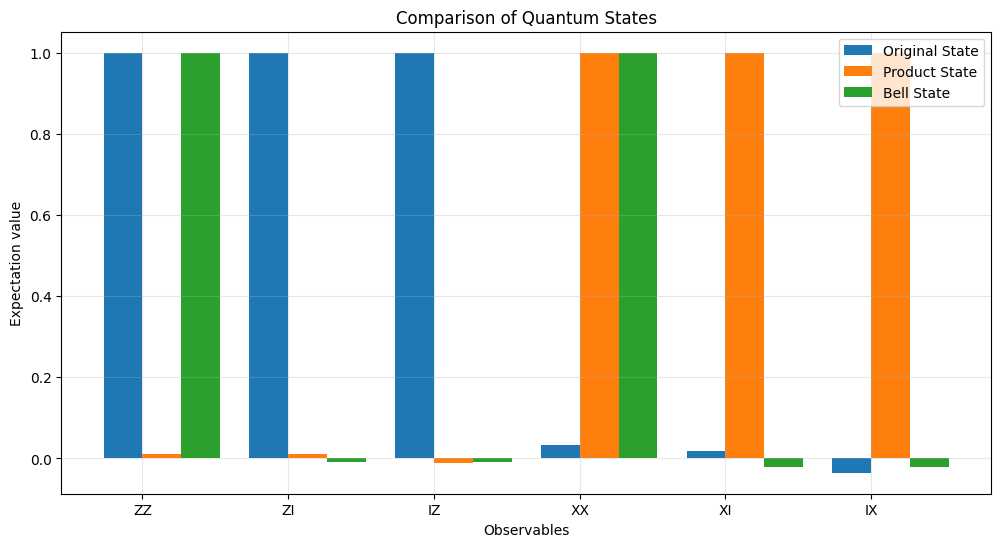

In [43]:
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import Pauli
import matplotlib.pyplot as plt
import numpy as np


def create_bell_state():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0, 1)
    return qc


def create_product_state():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.h(1)
    return qc


def measure_observables(circuit, observables):
    estimator = Estimator()
    job = estimator.run([circuit] * len(observables), observables)
    return job.result().values


def plot_expectations(results_dict, title="Quantum State Measurements"):
    plt.figure(figsize=(12, 6))
    x = np.arange(len(next(iter(results_dict.values()))))
    width = 0.8 / len(results_dict)

    for i, (state_name, values) in enumerate(results_dict.items()):
        plt.bar(x + i*width, values, width, label=state_name)

    plt.xlabel('Observables')
    plt.ylabel('Expectation value')
    plt.title(title)
    plt.xticks(x + width/2, ['ZZ', 'ZI', 'IZ', 'XX', 'XI', 'IX'])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


# Define observables
observables = [Pauli('ZZ'), Pauli('ZI'), Pauli('IZ'),
               Pauli('XX'), Pauli('XI'), Pauli('IX')]

# Create and measure different states
bell_state = create_bell_state()
product_state = create_product_state()

# Measure each state
results = {
    'Original State': measure_observables(QuantumCircuit(2), observables),
    'Product State': measure_observables(product_state, observables),
    'Bell State': measure_observables(bell_state, observables),
}

# Plot results
plot_expectations(results, "Comparison of Quantum States")